In [19]:
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import numpy as np
import eli5
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import cross_validate, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from scipy.stats import loguniform
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
from eli5.sklearn import PermutationImportance

hfont = {'fontname':'Helvetica'}
## read data 
CIP_data_no_drop = pd.read_csv("CIP_data_encode_prev_not_dropped.csv")


In [3]:
def get_features_based_on_importance_rank(features, importance_col_name, importance_value, n_features_wanted):
    """ create a sorted table containing feature name and its importance score
    :param features: list of feature names
    :param importance_col_name: the name of the column which shows the importance value or rank for each feature
    :param importance_value: the importance value or rank for each feature
    :param n_features_wanted: number of features you want to select
    :return a sorted DataFrame containing the name of feature and its corresponding importance
    """

    # creat a DataFrame
    d = {'Features': features, importance_col_name: importance_value}
    df = pd.DataFrame(d)
    # sort by descending
    df = df.sort_values(by=[importance_col_name], ascending=False)
    selected_feature_names = (df['Features'][0: n_features_wanted]).tolist()
    return selected_feature_names

In [ ]:
## PI - frequency of importance 

n_iterations = 500
PI_dataframe = pd.DataFrame({
'MSM':0,
'MSMW':0,
'MSW':0,
'Other':0,
'Midwest':0,
'Northeast':0,
'West':0,
'Southeast':0,
'Southwest':0,
'Region':0,
'Clinic':0, 
'Delta':0},index=[0])

PI_dataframe_all = pd.DataFrame()

model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 13, alpha = 1.291549665014884, random_state=10, learning_rate = 'constant' )
feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']
#Generate new test and train data 
            # train
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010])]
X_train_standard = train_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_train_standard = train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5)
X_train, y_train = oversample.fit_resample(X_train_standard,y_train_standard)

            # test
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011])]
X_test_standard = test_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_test_standard = test_data['Susceptible']
oversample = RandomOverSampler(sampling_strategy = 0.5)
X_test, y_test = oversample.fit_resample(X_test_standard,y_test_standard)

model_fit_train = model_nn.fit(X_train_standard, y_train_standard)

for i in range(n_iterations):

    # Train model on training data - don't need to test on test data 
    X_train, y_train = oversample.fit_resample(X_train_standard,y_train_standard)
    X_test, y_test = oversample.fit_resample(X_test_standard,y_test_standard)

    model_fit_train = model_nn.fit(X_train, y_train)
    # Permutation importance 
    PI = permutation_importance(model_fit_train, X_test, y_test, n_repeats = 10, random_state = 42)
    important_features = get_features_based_on_importance_rank(feature_names, 'Importance', PI.importances_mean, 5)
    for feature in important_features:
        if feature == 'PREV_CLINIC':
                PI_dataframe["Clinic"] += 1
        elif feature == "PREV_REGION":
                PI_dataframe["Region"] += 1
        elif feature == "MSM":
                PI_dataframe["MSM"] += 1
        elif feature == "MSMW":
                PI_dataframe["MSMW"] += 1
        elif feature == "MSW":
                PI_dataframe["MSW"] += 1
        elif feature == "Oth/Unk/Missing":
                PI_dataframe["Other"] += 1  
        elif feature == "Northeast":
                PI_dataframe["Northeast"] += 1 
        elif feature == "Southeast":
                PI_dataframe["Southeast"] += 1    
        elif feature == "Southewest":
                PI_dataframe["Southwest"] += 1   
        elif feature == "Midwest":
                PI_dataframe["Midwest"] += 1    
        elif feature == "West":
                PI_dataframe["West"] += 1   
        elif feature == "DELTA_REGION":
                PI_dataframe["Delta"] += 1

    #Save results. 1 = +ve, -1 = -ve 



In [8]:
print(PI_dataframe)

   MSM  MSMW  MSW  Other  Midwest  Northeast  West  Southeast  Southwest  \
0  353     0  229      0      156        103   455        168          0   

   Region  Clinic  Delta  
0     474     448     74  


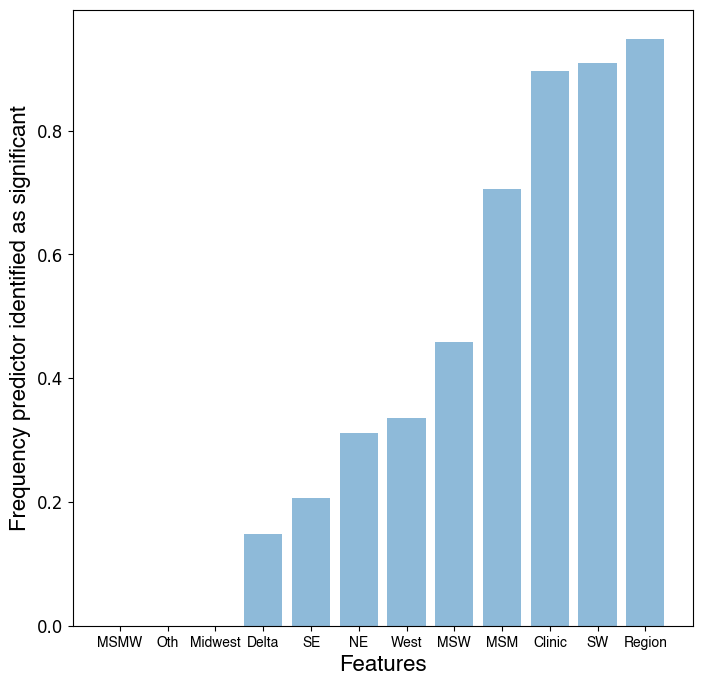

In [13]:
feature_names = ['MSM','MSMW', 'MSW', 'Oth','NE', 'SE', 'SW', 'West', 'Midwest','Region', 'Clinic', 'Delta']
PI_dataframe = pd.DataFrame({
'MSM':353,
'MSMW': 0,
'MSW': 229,
'Other':0,
'Midwest':156,
'Northeast':103,
'West': 455,
'Southeast': 168,
'Southwest':0,
'Region':474,
'Clinic':448, 
'Delta': 74},index=[0])

PI_dataframe = pd.DataFrame({
'Features': feature_names,
'Importance': [353, 0, 229, 0, 156, 103, 455, 168, 0, 474, 448, 74]})

PI_dataframe_sorted = PI_dataframe.sort_values('Importance')
PI_dataframe_sorted["Importance"]  = PI_dataframe_sorted["Importance"]/500
plt.rcParams['figure.figsize'] = [8, 8]
y_pos = np.arange(len(feature_names))
plt.bar('Features', 'Importance', data =  PI_dataframe_sorted, align='center', alpha=0.5)
plt.xticks(y_pos, **hfont)
plt.yticks(fontsize=12)
plt.xlabel('Features', **hfont, fontsize=16)
plt.ylabel('Frequency predictor identified as significant', **hfont,fontsize=16)
plt.savefig('Features_by_importance.png')

<Figure size 800x800 with 0 Axes>

In [24]:
## permutation importance on test data 
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 12, alpha = 1.291549665014884, random_state=10, learning_rate = 'adaptive' )
#train data: 2000 - 2009
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,2010])]
X_train = train_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_train = 1 - train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5, random_state=42)
X_train, y_train = oversample.fit_resample(X_train,y_train)
model_fit = model_nn.fit(X_train, y_train)

#test data: 2010 - 2019 
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]
X_test = test_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_test = 1 - test_data['Susceptible']
oversample = RandomOverSampler(sampling_strategy = 0.5, random_state=42)
X_test, y_test = oversample.fit_resample(X_test,y_test)

y_predict = model_nn.predict(X_test)

ROC_AUC_neural_network_apparent = metrics.roc_auc_score(y_test, y_predict)

perm = permutation_importance(model_fit, X_train, y_train, random_state=1)#.fit(X_test,y_test)
#eli5.show_weights(perm, feature_names = X_test.columns.tolist())

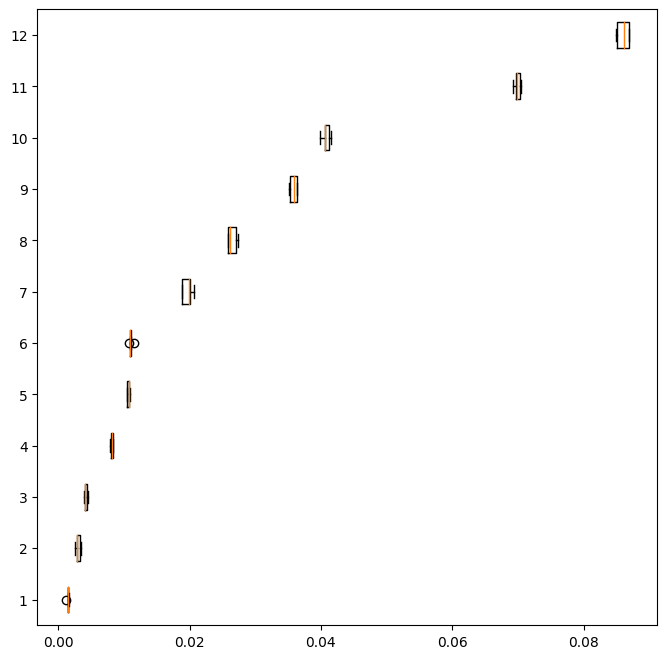

In [31]:
perm_sorted_idx = perm.importances_mean.argsort()
feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']
#tree_importance_sorted_idx = np.argsort(model_nn.feature_importances_)
#tree_indices = np.arange(0, len(model_nn.feature_importances_)) + 0.5

#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
#ax1.barh(tree_indices, model_nn.feature_importances_[tree_importance_sorted_idx], height=0.7)
#ax1.set_yticks(tree_indices)
#ax1.set_yticklabels(CIP_data_no_drop.feature_names[tree_importance_sorted_idx])
#ax1.set_ylim((0, len(model_nn.feature_importances_)))
plt.boxplot(
    perm.importances[perm_sorted_idx].T,
    vert=False,
    #labels=feature_names[perm_sorted_idx],
)
plt.show()

In [43]:
## What happens to feature importance if you only train on the 2011 data?

n_iterations = 100
PI_dataframe_2011 = pd.DataFrame({
'MSM':0,
'MSMW':0,
'MSW':0,
'Other':0,
'Midwest':0,
'Northeast':0,
'West':0,
'Southeast':0,
'Southwest':0,
'Region':0,
'Clinic':0},index=[0])

model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 13, alpha = 1.291549665014884, random_state=10, learning_rate = 'constant' )
feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC']

for i in range(n_iterations):
    #Generate new test and train data 
            # train
    train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010])]
    X_train = train_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC']]
    y_train = train_data['Susceptible']

    oversample = RandomOverSampler(sampling_strategy = 0.5)
    X_train, y_train = oversample.fit_resample(X_train,y_train)

            # test
    test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011])]
    X_test = test_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC']]
    y_test = test_data['Susceptible']
    oversample = RandomOverSampler(sampling_strategy = 0.5)
    X_test, y_test = oversample.fit_resample(X_test,y_test)

    # Train model on training data - don't need to test on test data 
    model_fit_train = model_nn.fit(X_train, y_train)

    # Permutation importance 
    PI = permutation_importance(model_fit_train, X_test, y_test, n_repeats = 10, random_state = 42)
    important_features = get_features_based_on_importance_rank(feature_names, 'Importance', PI.importances_mean, 5)
    for feature in important_features:
        if feature == 'PREV_CLINIC':
                PI_dataframe_2011["Clinic"] += 1
        elif feature == "PREV_REGION":
                PI_dataframe_2011["Region"] += 1
        elif feature == "MSM":
                PI_dataframe_2011["MSM"] += 1
        elif feature == "MSMW":
                PI_dataframe_2011["MSMW"] += 1
        elif feature == "MSW":
                PI_dataframe_2011["MSW"] += 1
        elif feature == "Oth/Unk/Missing":
                PI_dataframe_2011["Other"] += 1  
        elif feature == "Northeast":
                PI_dataframe_2011["Northeast"] += 1 
        elif feature == "Southeast":
                PI_dataframe_2011["Southeast"] += 1    
        elif feature == "Southewest":
                PI_dataframe_2011["Southwest"] += 1   
        elif feature == "Midwest":
                PI_dataframe_2011["Midwest"] += 1    
        elif feature == "West":
                PI_dataframe_2011["West"] += 1   

    #Save results. 1 = +ve, -1 = -ve 

/var/folders/3f/vvt02dh16jddhc3q1tl6f3zh0000gn/T/ipykernel_85583/1347534679.py:15: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected_feature_names = (df['Features'][0: n_features_wanted]).tolist()
/var/folders/3f/vvt02dh16jddhc3q1tl6f3zh0000gn/T/ipykernel_85583/1347534679.py:15: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected_feature_names = (df['Features'][0: n_features_wanted]).tolist()
/var/folders/3f/vvt02dh16jddhc3q1tl6f3zh0000gn/T/ipykernel_85583/1347534679.py:1

In [42]:
print(PI_dataframe)

   MSM  MSMW  MSW  Other  Midwest  Northeast  West  Southeast  Southwest  \
0    9     0    9      0        0          1     8          4          0   

   Region  Clinic  
0      10       9  


In [ ]:
feature_names = ['MSM','MSMW', 'MSW', 'Oth','NE', 'SE', 'SW', 'West', 'Midwest','Region', 'Clinic']
PI_dataframe_2011 = pd.DataFrame({
'MSM':83,
'MSMW': 40,
'MSW': 90,
'Other':8,
'Midwest':24,
'Northeast':34,
'West': 40,
'Southeast': 32,
'Southwest':0,
'Region':37,
'Clinic':100},index=[0])

PI_dataframe = pd.DataFrame({
'Features': feature_names,
'Importance': [83, 40, 90, 8, 24, 34, 40, 32, 0, 37, 100]})

PI_dataframe_sorted = PI_dataframe.sort_values('Importance')
PI_dataframe_sorted["Importance"]  = PI_dataframe_sorted["Importance"]/100
plt.rcParams['figure.figsize'] = [8, 8]
y_pos = np.arange(len(feature_names))
plt.bar('Features', 'Importance', data =  PI_dataframe_sorted, align='center', alpha=0.5)
plt.xticks(y_pos, **hfont)
plt.yticks(fontsize=12)
plt.xlabel('Features', **hfont, fontsize=16)
plt.ylabel('Frequency predictor identified as significant', **hfont,fontsize=16)
